# Dataset integration

In this tutorial, we will integrate a differential centrifugation (DC) dataset with an organellar immunoprecipitation (OrgIP) dataset.

While DC is a more scalable technique, OrgIP provides significantly higher resolution. A practical approach to achieving high-resolution mapping is to strategically supplement DC data with targeted IP pulldowns for cellular compartments that are poorly resolved by centrifugation alone. 

Although we merge two complete datasets in this example, real-world applications typically involve combining a DC dataset with only a small number of strategic IPs. 

This integration process is streamlined using the grassp package.

In [1]:
import grassp as gr
import scanpy as sc
import anndata as ad
import numpy as np

## Loading Data


In [2]:
# load DC dataset (hek cells)
dc = gr.ds.hek_dc_2025(enrichment="enriched")
dc

AnnData object with n_obs × n_vars = 8599 × 7
    obs: 'Majority protein IDs', 'Peptide counts (all)', 'Peptide counts (razor+unique)', 'Peptide counts (unique)', 'Protein names', 'Gene names', 'Fasta headers', 'Number of proteins', 'Peptides', 'Razor + unique peptides', 'Unique peptides', 'Sequence coverage [%]', 'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]', 'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths', 'Fraction average', 'Fraction 1', 'Fraction 2', 'Fraction 3', 'Q-value', 'Score', 'Intensity', 'iBAQ', 'MS/MS count', 'id', 'Peptide IDs', 'Peptide is razor', 'Mod. peptide IDs', 'Evidence IDs', 'MS/MS IDs', 'Best MS/MS', 'Oxidation (M) site IDs', 'Oxidation (M) site positions', 'n_samples_by_intensity', 'mean_intensity', 'log1p_mean_intensity', 'pct_dropout_by_intensity', 'total_intensity', 'log1p_total_intensity', 'gene_symbol', 'hein2024_component', 'hein2024_gt_component', 'itzhak2016_component'
    var: 'subcellular_enrichment', 'n_merged_sa

In [3]:
# OrgIP dataset (hek cells)
orgip = gr.ds.hein_2024(enrichment="enriched")
orgip

AnnData object with n_obs × n_vars = 8538 × 61
    obs: 'Majority protein IDs', 'Protein IDs', 'Gene names', 'Gene_name_canonical', 'curated_ground_truth_v9.0', 'cluster_annotation', 'Graph-based_localization_annotation', 'consensus_graph_annnotation', 'gene_symbol', 'hein2024_component', 'hein2024_gt_component', 'itzhak2016_component', 'ComplexName', 'gene_name', 'uniprot_id', 'Protein names', 'Fasta headers', 'Number of proteins', 'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]', 'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths', 'Fraction average', 'Fraction 1', 'Fraction 101', 'Fraction 102', 'Fraction 103', 'Q-value', 'Score', 'Only identified by site', 'Reverse', 'Potential contaminant', 'id', 'n_samples_by_intensity', 'mean_intensity', 'log1p_mean_intensity', 'pct_dropout_by_intensity', 'total_intensity', 'log1p_total_intensity'
    var: 'subcellular_enrichment', 'covariate_Experiment', 'mean', 'std'
    uns: 'hein2024_component_colors', 'neighbors

## Plotting individual maps

Next, we use UMAP to visualize the spatial organization of the datasets. This helps us qualitatively assess how well the biological compartments are resolved before proceeding with downstream integration or analysis.

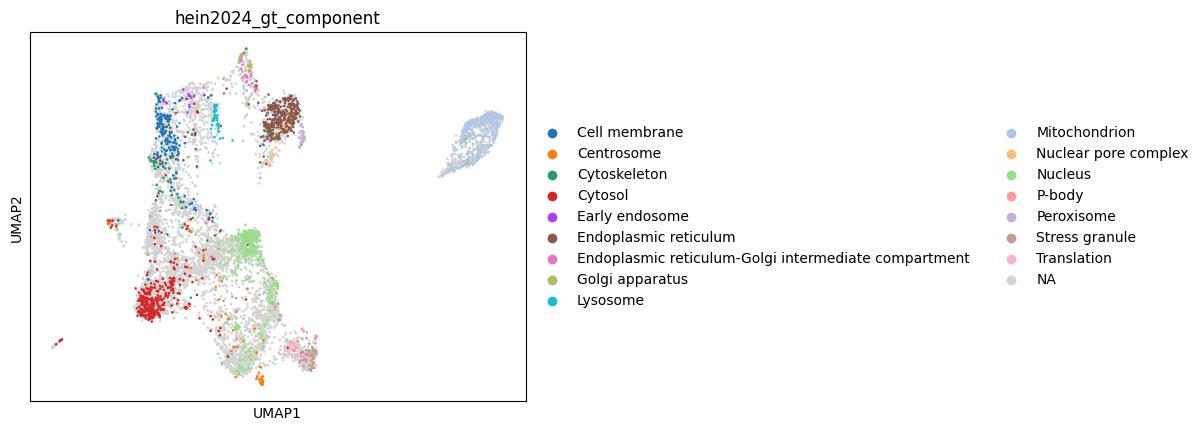

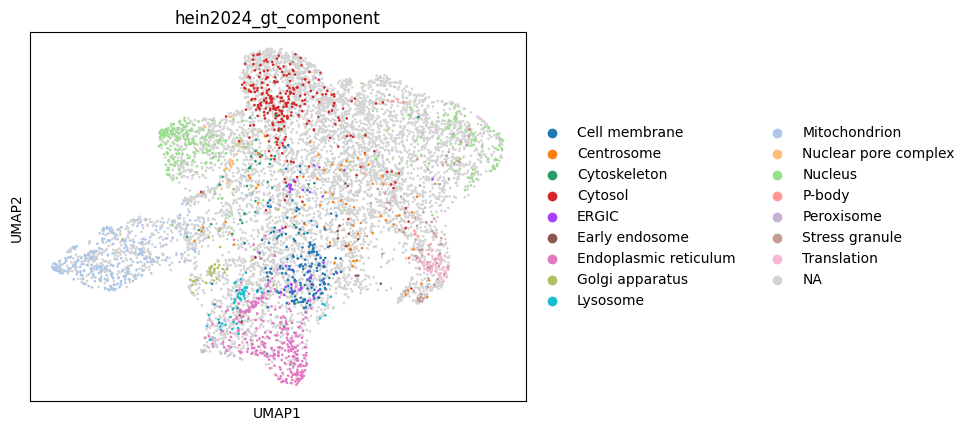

In [4]:
sc.pl.umap(orgip, color="hein2024_gt_component")
sc.pl.umap(dc, color="hein2024_gt_component")

## Integration

To integrate the two datasets, we must identify a common gene or protein identifier to facilitate matching. While UniProt IDs or gene names are typical candidates, direct merging via UniProt IDs is challenging in this case because one dataset was searched against Swiss-Prot and the other against TrEMBL. To ensure consistency, we will first collapse all entries based on their gene names.

In [ ]:
# aggregate proteins in the DC dataset
dc = dc[dc.obs["Gene names"].notna()]
dc_agg = gr.pp.aggregate_proteins(dc, grouping_columns="Gene names", agg_func=np.mean)
dc_agg.obs.head()

,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Protein names,Gene names,Fasta headers,Number of proteins,Peptides,Razor + unique peptides,...,mean_intensity,log1p_mean_intensity,pct_dropout_by_intensity,total_intensity,log1p_total_intensity,gene_symbol,hein2024_component,hein2024_gt_component,itzhak2016_component,n_merged_proteins
AAAS,Q9NRG9;Q9NRG9-2,24;20,24;20,24;20,Aladin,AAAS,sp|Q9NRG9|AAAS_HUMAN Aladin OS=Homo sapiens OX...,2,24,24,...,2193667009.523809,21.50884,0.0,92134023168.0,25.24651,AAAS,Endoplasmic reticulum,NaN,NaN,1
AACS,Q86V21;Q86V21-2;Q86V21-3,28;21;15,28;21;15,28;21;15,Acetoacetyl-CoA synthetase,AACS,sp|Q86V21|AACS_HUMAN Acetoacetyl-CoA synthetas...,3,28,28,...,314310622.095238,19.565892,2.380952,13201046528.0,23.303562,AACS,Cytosol,NaN,NaN,1
AADAT,Q8N5Z0;Q8N5Z0-2,9;8,9;8,9;8,Kynurenine/alpha-aminoadipate aminotransferase...,AADAT,sp|Q8N5Z0|AADAT_HUMAN Kynurenine/alpha-aminoad...,2,9,9,...,52776511.52381,17.781577,50.0,2216613632.0,21.519247,NaN,NaN,NaN,NaN,1
AAED1,Q7RTV5,4,4,4,Thioredoxin-like protein AAED1,AAED1,sp|Q7RTV5|PXL2C_HUMAN Peroxiredoxin-like 2C OS...,1,4,4,...,15247564.285714,16.53993,47.619048,640397696.0,20.277599,NaN,NaN,NaN,NaN,1
AAGAB,Q6PD74;Q6PD74-2,10;6,10;6,10;6,Alpha- and gamma-adaptin-binding protein p34,AAGAB,sp|Q6PD74|AAGAB_HUMAN Alpha- and gamma-adaptin...,2,10,10,...,478817880.571429,19.986831,0.0,20110352384.0,23.724501,AAGAB,Cytosol,Cytosol,NaN,1


In [ ]:
# aggregate proteins in the OrgIP dataset
orgip_agg = gr.pp.aggregate_proteins(
    orgip, grouping_columns="Gene_name_canonical", agg_func=np.mean
)
orgip_agg.obs_names = orgip_agg.obs_names.str.upper()
orgip_agg.obs.head()

,Majority protein IDs,Protein IDs,Gene names,Gene_name_canonical,curated_ground_truth_v9.0,cluster_annotation,Graph-based_localization_annotation,consensus_graph_annnotation,gene_symbol,hein2024_component,...,Reverse,Potential contaminant,id,n_samples_by_intensity,mean_intensity,log1p_mean_intensity,pct_dropout_by_intensity,total_intensity,log1p_total_intensity,n_merged_proteins
A0A2R8Y3M9[P],A0A2R8Y3M9,A0A2R8Y3M9,NaN,A0A2R8Y3M9[p],NaN,unclassified,unclassified,unclassified,NaN,NaN,...,False,False,2564,14,477612.021858,13.076556,92.349727,87403000.0,18.286039,1
A0A3B3ITR4[P],A0A3B3ITR4,A0A3B3ITR4;A0A0C4DG23;C9J718;C9JF32;C9JBN7;C9J...,NaN,A0A3B3ITR4[p],NaN,recycling_endosome,recycling_endosome,recycling_endosome,NaN,NaN,...,False,False,2961,136,8201691.114754,15.919851,25.68306,1500909568.0,21.129337,1
A0A5C2GRJ2[P],A0A5C2GRJ2,A0A5C2GRJ2,NaN,A0A5C2GRJ2[p],NaN,unclassified,unclassified,unclassified,NaN,NaN,...,False,False,3198,143,4939933.333333,15.412863,21.857923,904007808.0,20.622349,1
A0A7D5Y1P9[P],A0A7D5Y1P9,A0A7D5Y1P9,NaN,A0A7D5Y1P9[p],NaN,unclassified,unclassified,unclassified,NaN,NaN,...,False,False,3409,11,367062.295082,12.81329,93.989071,67172400.0,18.022774,1
A0A024RBS8[P],A0A024RBS8,A0A024RBS8,hCG_1744452,A0A024RBS8[p],NaN,nucleus,nucleus,nucleus,NaN,NaN,...,False,False,1262,9,191690.163934,12.163641,95.081967,35079300.0,17.373121,1


In [ ]:
# combine the two datasets, keep only the common proteins, 
combined = ad.concat(
    [dc_agg, orgip_agg],
    axis=1, # This specifies a horizontal concatenation. We are keeping the proteins as rows and concatenating the experimental fractions or pulldowns from both datasets as columns.
    join="inner",
    merge="first",
    keys=["dc", "orgip"],
    label="dataset",
)
combined

AnnData object with n_obs × n_vars = 7014 × 68
    obs: 'Majority protein IDs', 'Peptide counts (all)', 'Peptide counts (razor+unique)', 'Peptide counts (unique)', 'Protein names', 'Gene names', 'Fasta headers', 'Number of proteins', 'Peptides', 'Razor + unique peptides', 'Unique peptides', 'Sequence coverage [%]', 'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]', 'Mol. weight [kDa]', 'Sequence length', 'Sequence lengths', 'Fraction average', 'Fraction 1', 'Fraction 2', 'Fraction 3', 'Q-value', 'Score', 'Intensity', 'iBAQ', 'MS/MS count', 'id', 'Peptide IDs', 'Peptide is razor', 'Mod. peptide IDs', 'Evidence IDs', 'MS/MS IDs', 'Best MS/MS', 'Oxidation (M) site IDs', 'Oxidation (M) site positions', 'n_samples_by_intensity', 'mean_intensity', 'log1p_mean_intensity', 'pct_dropout_by_intensity', 'total_intensity', 'log1p_total_intensity', 'gene_symbol', 'hein2024_component', 'hein2024_gt_component', 'itzhak2016_component', 'n_merged_proteins', 'Protein IDs', 'Gene_nam

In [ ]:
# compute UMAP embeddings
sc.pp.neighbors(combined, use_rep="X")
sc.tl.umap(combined, min_dist=0.1)

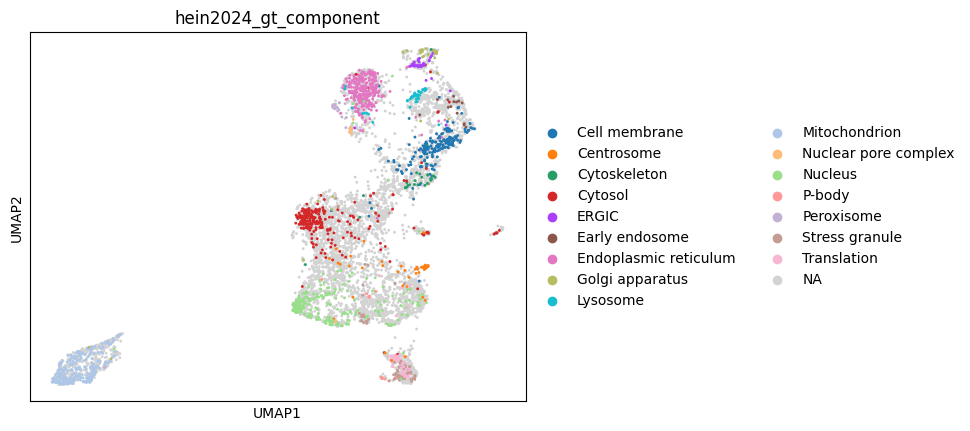

In [ ]:
# plot UMAP of the integrated dataset
sc.pl.umap(combined, color="hein2024_gt_component")